In [1]:
import pandas as pd

# Load datasets
customers = pd.read_csv("Customers.csv")
products = pd.read_csv("Products.csv")
transactions = pd.read_csv("Transactions.csv")

In [2]:
# Merge datasets
merged_data = transactions.merge(customers, on="CustomerID").merge(products, on="ProductID")
print(merged_data.head())

  TransactionID CustomerID ProductID      TransactionDate  Quantity  \
0        T00001      C0199      P067  2024-08-25 12:38:23         1   
1        T00112      C0146      P067  2024-05-27 22:23:54         1   
2        T00166      C0127      P067  2024-04-25 07:38:55         1   
3        T00272      C0087      P067  2024-03-26 22:55:37         2   
4        T00363      C0070      P067  2024-03-21 15:10:10         3   

   TotalValue  Price_x     CustomerName         Region  SignupDate  \
0      300.68   300.68   Andrea Jenkins         Europe  2022-12-03   
1      300.68   300.68  Brittany Harvey           Asia  2024-09-04   
2      300.68   300.68  Kathryn Stevens         Europe  2024-04-04   
3      601.36   300.68  Travis Campbell  South America  2024-04-11   
4      902.04   300.68    Timothy Perez         Europe  2022-03-15   

                       ProductName     Category  Price_y  
0  ComfortLiving Bluetooth Speaker  Electronics   300.68  
1  ComfortLiving Bluetooth Speaker

In [3]:
# Aggregate features for customers
customer_features = merged_data.groupby("CustomerID").agg(
    TotalSpending=("TotalValue", "sum"),
    TransactionFrequency=("TransactionID", "nunique")
).reset_index()

In [4]:
# Add category preferences
category_prefs = pd.pivot_table(
    merged_data,
    index="CustomerID",
    columns="Category",
    values="Quantity",
    aggfunc="sum",
    fill_value=0
).reset_index()

In [5]:
# Merge features
customer_features = customer_features.merge(category_prefs, on="CustomerID")
print(customer_features.head())

  CustomerID  TotalSpending  TransactionFrequency  Books  Clothing  \
0      C0001        3354.52                     5      2         0   
1      C0002        1862.74                     4      0         4   
2      C0003        2725.38                     4      0         4   
3      C0004        5354.88                     8      8         0   
4      C0005        2034.24                     3      0         0   

   Electronics  Home Decor  
0            7           3  
1            0           6  
2            4           6  
3            6           9  
4            4           3  


In [6]:
from sklearn.preprocessing import StandardScaler

# Normalize features
scaler = StandardScaler()
normalized_features = scaler.fit_transform(customer_features.iloc[:, 1:])

In [7]:
from sklearn.metrics.pairwise import cosine_similarity

# Compute cosine similarity
similarity_matrix = cosine_similarity(normalized_features)

In [8]:
# Create a DataFrame for easy access
similarity_df = pd.DataFrame(similarity_matrix, index=customer_features["CustomerID"], columns=customer_features["CustomerID"])
print(similarity_df.head())

CustomerID     C0001     C0002     C0003     C0004     C0005     C0006  \
CustomerID                                                               
C0001       1.000000 -0.323057  0.189517  0.222293  0.583006 -0.836235   
C0002      -0.323057  1.000000  0.740619 -0.413772  0.426889  0.137827   
C0003       0.189517  0.740619  1.000000 -0.201259  0.536835 -0.345058   
C0004       0.222293 -0.413772 -0.201259  1.000000 -0.427631 -0.192366   
C0005       0.583006  0.426889  0.536835 -0.427631  1.000000 -0.411362   

CustomerID     C0007     C0008     C0009     C0010  ...     C0191     C0192  \
CustomerID                                          ...                       
C0001       0.596059 -0.109688  0.027800 -0.643218  ... -0.077121  0.449518   
C0002       0.455898  0.031128  0.519927  0.401687  ... -0.556709 -0.130186   
C0003       0.620168  0.233947  0.253767  0.135473  ... -0.862575 -0.163888   
C0004      -0.292203  0.300643 -0.861581 -0.778517  ...  0.135306 -0.545208   
C0005  

In [9]:
# Get top 3 similar customers for the first 20 customers
lookalike_results = {}

for cust_id in customer_features["CustomerID"][:20]:
    similar_customers = similarity_df[cust_id].sort_values(ascending=False).iloc[1:4]
    lookalike_results[cust_id] = list(similar_customers.items())

In [10]:
# Convert to the required CSV format
lookalike_output = []

for cust_id, similar_list in lookalike_results.items():
    for sim_cust, score in similar_list:
        lookalike_output.append([cust_id, sim_cust, score])

lookalike_df = pd.DataFrame(lookalike_output, columns=["CustomerID", "SimilarCustomerID", "SimilarityScore"])
lookalike_df.to_csv("iranna_Lookalike.csv", index=False)

In [11]:
irannacsv=pd.read_csv("iranna_Lookalike.csv")
irannacsv.head()

,CustomerID,SimilarCustomerID,SimilarityScore
0,C0001,C0069,0.933006
1,C0001,C0026,0.904200
2,C0001,C0157,0.855824
3,C0002,C0178,0.956485
4,C0002,C0133,0.949490


# Insight:
For Customer C0001, the top 3 similar customers identified using the Lookalike Model are:

C0069 with a similarity score of 0.933

C0026 with a similarity score of 0.904

C0157 with a similarity score of 0.855

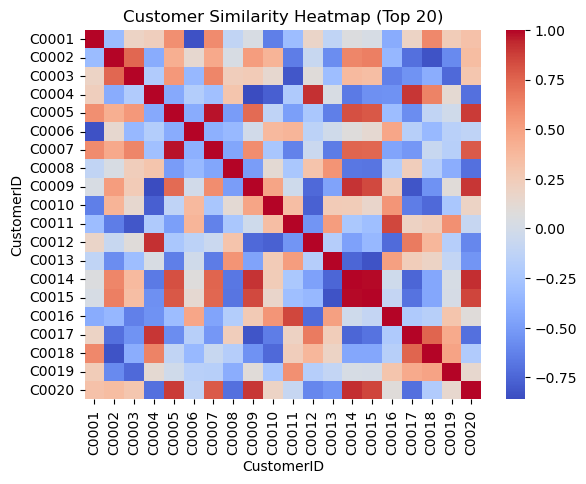

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(similarity_df.iloc[:20, :20], cmap="coolwarm", annot=False)
plt.title("Customer Similarity Heatmap (Top 20)")
plt.show()